# pyEMU basics

In this exercise, we will explore some of the capabilities of pyemu to deal with the PEST file formats, such as .pst, .jco/.jcb, .unc, .cov, .mat, etc, as well as generating PEST interface elements

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pyemu

flopy is installed in /Users/jeremyw/Dev/gw1876/activities_csiro/notebooks/flopy


In [2]:
pyemu.__path__  # check that we're pointing to the provided snapshot of pyemu (and flopy) repos

['/Users/jeremyw/Dev/gw1876/activities_csiro/notebooks/pyemu']

We will use some pre-cooked files in this notebook:

In [3]:
f_d = "handling_files"
os.listdir(f_d)

['freyberg_pp.rei',
 'freyberg.travel.ins',
 'test.par_data.csv',
 'test.pst',
 'test.pi_data.csv',
 'freyberg_pp.jcb',
 '.DS_Store',
 'vol.dat.ins',
 'freyberg.sfo.processed',
 'freyberg.rch.tpl',
 'freyberg.sfr.tpl',
 'WEL_0001.dat.temp.tpl',
 'flux.dat.ins',
 'freyberg.hyd.bin.dat',
 'freyberg_pp.post.cov',
 'test.obs_data.csv',
 'test.insfile_data.csv',
 'freyberg_pp.rec',
 'WEL_0002.dat.temp.tpl',
 'freyberg.sfo.processed.ins',
 'freyberg.hyd.bin.dat.ins',
 'hkpp.dat.fac',
 'hkpp.dat.tpl',
 'freyberg.mpbas.tpl',
 'freyberg_pp.pst',
 'test.tplfile_data.csv',
 'hkpp.dat',
 'freyberg_pp.par',
 'test.pargrp_data.csv',
 'freyberg.travel']

### Control files and the `Pst` class

pyEMU encapsulates the PEST control file in the `Pst` class

In [4]:
pst = pyemu.Pst(os.path.join(f_d,"freyberg_pp.pst"))

In [5]:
pst

The "*" sections of the control file are stored as attributes of the `Pst` instance (the PEST variable names are used for consistency)

In [8]:
pst.parameter_data.head()

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk00,hk00,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,NaN
hk01,hk01,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,NaN
hk02,hk02,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,NaN
hk03,hk03,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,NaN
hk04,hk04,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,NaN


In [9]:
pst.observation_data.head()

,obsnme,obsval,weight,obgnme,extra
obsnme,,,,,
c001cr03c10_19700102,c001cr03c10_19700102,26.661526,5.0,calhead,NaN
c001cr03c16_19700102,c001cr03c16_19700102,23.460564,5.0,calhead,NaN
c001cr04c09_19700102,c001cr04c09_19700102,28.513522,5.0,calhead,NaN
c001cr10c02_19700102,c001cr10c02_19700102,30.741689,5.0,calhead,NaN
c001cr14c11_19700102,c001cr14c11_19700102,25.871208,5.0,calhead,NaN


Control data is handled by a special class that tries to prevent stupidity

In [11]:
pst.control_data.noptmax = 0

PEST++ options are stored in a dict:

In [12]:
pst.pestpp_options

{'n_iter_base': '-1',
 'lambda_scale_fac': '1.0',
 'n_iter_super': '3',
 'lambdas': '0.1,1.0,10.0',
 'forecasts': 'travel_time,fa_headwaters_0001,c001fr16c17_19791231,c001fr05c04_19791231',
 'upgrade_augment': 'false'}

### Writing a control file

In [13]:
pst.write(os.path.join(f_d,"test.pst"))

noptmax:0, npar_adj:48, nnz_obs:14


A preview of things to come...

In [14]:
pst.write(os.path.join(f_d,"test.pst"),version=2)

noptmax:0, npar_adj:48, nnz_obs:14


### Constructing a control file from template and instruction files

### DIY: get a new control file from a template file (or files) and an instruction file (or files).  You can use the files in the `f_d` directory or you can write your own.  Change par bounds and obs weights then write

In [25]:
# your code here
#print(os.listdir(f_d))
# a template file
tpl_files = [os.path.join(f_d,"WEL_0001.dat.temp.tpl")]
# and the cooresponding model input file
in_files = [os.path.join(f_d,"WEL_0001.dat")]

# an instruction file
ins_files = [os.path.join(f_d,"freyberg.travel.ins")]
# and the cooresponding model output file
out_files = [os.path.join(f_d,"freyberg.travel")]


pst_new = pyemu.Pst.from_io_files(tpl_files,in_files,
                                  ins_files,out_files)
# adjust upper and lower parameter bounds
pst_new.parameter_data.loc[:,"parubnd"] = 100.0
pst_new.parameter_data.loc[:,"parlbnd"] = 0.1
# set all weights to 0.0
pst_new.observation_data.loc[:,"weight"] = 0.0


pst_new.write("temp.pst")
pst_new.par_names

noptmax:30, npar_adj:6, nnz_obs:0


['w0_r09_c16',
 'w0_r11_c13',
 'w0_r20_c14',
 'w0_r26_c10',
 'w0_r29_c06',
 'w0_r34_c12']

# Matrices

pyEMU implements a labeled matrix class and overloads the standard operators to make linear alg easier.  Let's start with covariance matrices:

In [26]:
cov = pyemu.Cov.from_parameter_data(pst)
cov

In [27]:
cov.row_names[:5]

['hk00', 'hk01', 'hk02', 'hk03', 'hk04']

In [28]:
cov.col_names[:5]

['hk00', 'hk01', 'hk02', 'hk03', 'hk04']

In [29]:
cov.isdiagonal

True

the `Cov` has some nice build-in methods:

In [30]:
cov.inv

In [31]:
cov.s #singular values

In [32]:
cov.v #right singular vectors

The actual array of values in the `.x` attribute:

In [33]:
cov.x[0:5]

array([[0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25]])

In [34]:
type(cov),type(cov.x)

(pyemu.mat.mat_handler.Cov, numpy.ndarray)

Why is this 1-D?

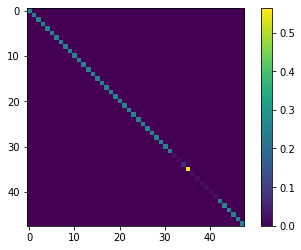

In [35]:
c = plt.imshow(cov.as_2d)
plt.colorbar(c)

In [36]:
post_cov = pyemu.Cov.from_ascii(os.path.join(f_d,"freyberg_pp.post.cov"))
post_cov.isdiagonal

False

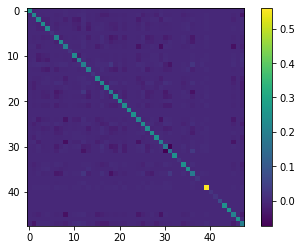

In [37]:
c = plt.imshow(post_cov.x)
plt.colorbar(c)

### DIY: plot the singular spectrum of the posterior covariance matrix.  Then convert the posterior covariance matrix to correlation matrix, mask the diagonal and plot

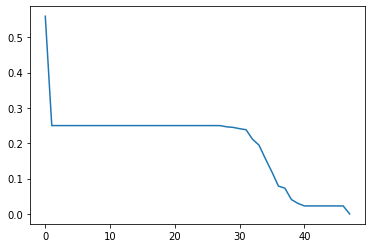

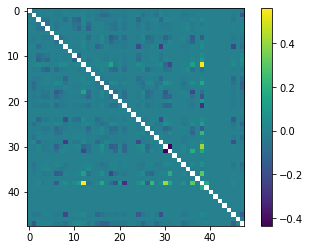

In [47]:
#hint: Cov.to_pearson()
plt.plot(post_cov.s.x)
plt.show()
post_cov.s.isdiagonal
cc = post_cov.to_pearson()
x = cc.x
indices = np.arange(x.shape[0])
x[indices,indices] = np.nan
cb = plt.imshow(cc.x)
plt.colorbar(cb)

### Residual handling

The `Pst` class tries load a residuals file in the constructor.  If that file is found, you can access some pretty cool stuff (you can pass the name of a residual file to the `Pst` constructor...).  The `res` attribute is stored as a `pd.DataFrame`

In [48]:
pst.phi

412.55703718999183

In [49]:
pst.phi_components

{'calflux': 0.6561000000000001,
 'calhead': 411.90093718999185,
 'flaqx': 0.0,
 'flout': 0.0,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_storage': 0.0,
 'flx_stream_': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'forecast': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_storage': 0.0,
 'vol_stream_': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [50]:
pst.res.head()

,name,group,measured,modelled,residual,weight
name,,,,,,
c001cr03c10_19700102,c001cr03c10_19700102,calhead,26.661526,28.013775,-1.352249,5.0
c001cr03c16_19700102,c001cr03c16_19700102,calhead,23.460564,24.444290,-0.983726,5.0
c001cr04c09_19700102,c001cr04c09_19700102,calhead,28.513522,28.513071,0.000451,5.0
c001cr10c02_19700102,c001cr10c02_19700102,calhead,30.741689,31.881250,-1.139561,5.0
c001cr14c11_19700102,c001cr14c11_19700102,calhead,25.871208,25.444475,0.426733,5.0


### DIY: plot a bar chart of residuals for non-zero weighted obs

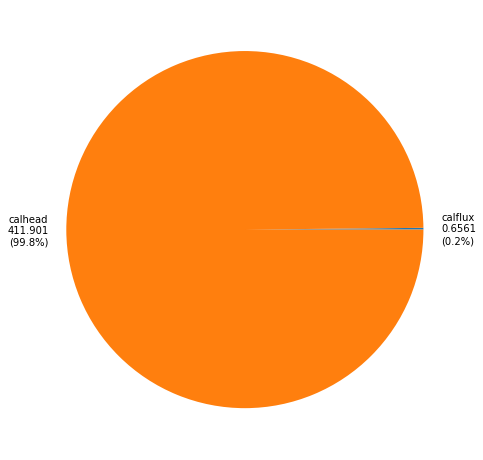

In [51]:
pst.plot(kind="phi_pie")

### The Jacobian matrix

A dervied pyemu.Matrix type...

In [52]:
jco = pyemu.Jco.from_binary(os.path.join(f_d,"freyberg_pp.jcb"))

In [53]:
df = jco.to_dataframe()
df.head()

,hk00,hk01,hk02,hk03,hk04,hk05,hk06,hk07,hk08,hk09,...,w0_r20_c14,w0_r26_c10,w0_r29_c06,w0_r34_c12,w1_r09_c16,w1_r11_c13,w1_r20_c14,w1_r26_c10,w1_r29_c06,w1_r34_c12
c001cr03c10_19700102,0.047670,0.166151,-1.466431,-1.587458,0.073819,-0.245292,-1.073273,-1.204015,0.009025,-0.548900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c001cr03c16_19700102,0.000694,0.003471,0.008331,0.021984,0.000694,-0.000926,-0.007174,-0.033323,0.000000,-0.005785,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c001cr04c09_19700102,0.054844,-0.079373,-1.573573,-1.353273,0.119869,-0.406120,-1.417377,-1.219288,0.011339,-0.668769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c001cr10c02_19700102,-0.292499,-0.813631,-0.924243,-0.749299,-1.115615,-1.743888,-1.162596,-0.765266,-0.549363,-0.664141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c001cr14c11_19700102,-0.021984,-0.089092,-0.356599,-0.520205,0.062711,0.314020,-0.098811,-0.733563,0.087241,-0.066183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Some sweet potting sugar:

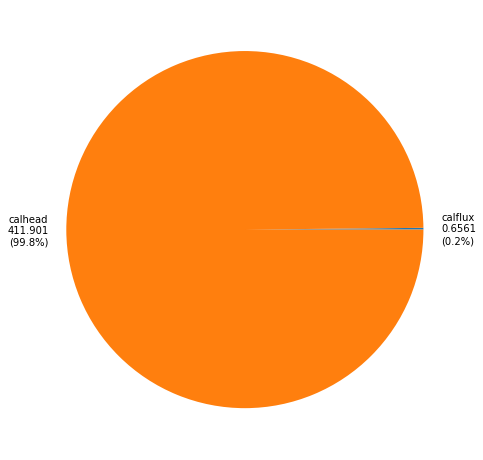

In [54]:
pst.plot(kind="phi_pie")

[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

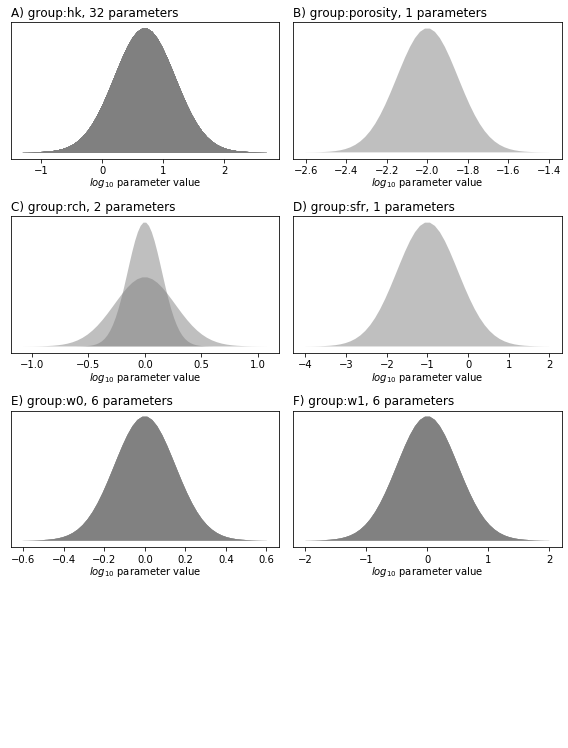

In [55]:
pst.plot(kind='prior')

[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

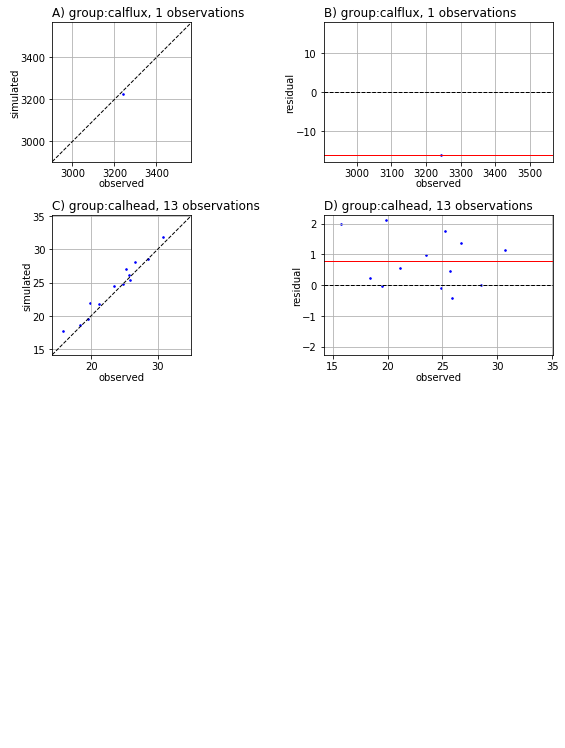

In [56]:
pst.plot(kind="1to1")

In [58]:
pst.write_par_summary_table(filename="par.tex")

,group,value,non-zero weight,zero weight,weight,standard deviation,percent error
calflux,calflux,3242.6,1,0,0.05,20,0.616789
calhead,calhead,15.7487 to 30.7417,13,0,5,0.2,0.650582 to 1.26995
flaqx,flaqx,-895.43 to 252.98,0,122,0,NA,NA
flout,flout,0 to 7229.3,0,122,0,NA,NA
flx_constan,flx_constan,-860.052 to -490.431,0,3,0,NA,NA
flx_in-out,flx_in-out,-2.9966 to 1.3086,0,3,0,NA,NA
flx_percent,flx_percent,-0.05 to 0.02,0,3,0,NA,NA
flx_recharg,flx_recharg,3475 to 6004.8,0,3,0,NA,NA
flx_storage,flx_storage,0 to 1578.27,0,3,0,NA,NA
flx_stream_,flx_stream_,-3242.62 to -603.149,0,3,0,NA,NA


### DIY: Adjust the weights so that both non-zero obs groups contribute equally to the objective function (and plot!) - no model runs required...

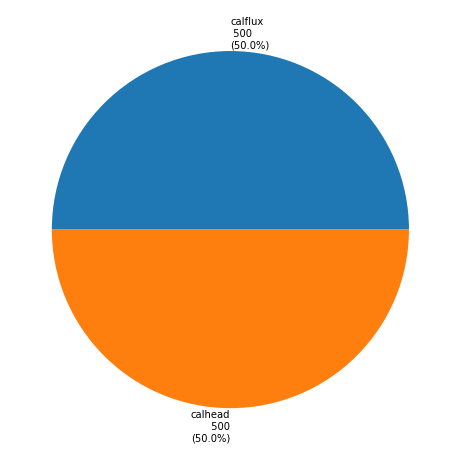

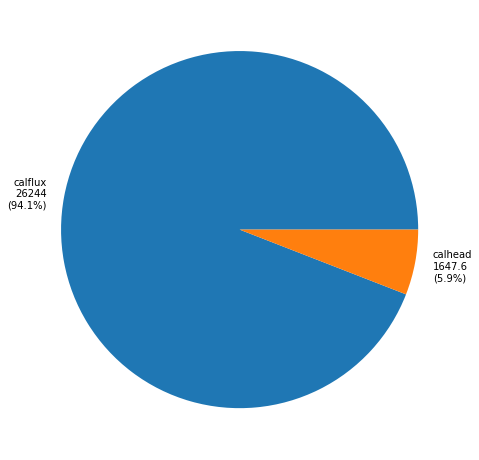

In [61]:
# hint: pst.adjust_weights
obsgrp_dict = {}
for nnz_obsgrp in pst.nnz_obs_groups:
    obsgrp_dict[nnz_obsgrp] = 500.0
pst.adjust_weights(obsgrp_dict=obsgrp_dict)
pst.plot(kind="phi_pie")
pst.write("temp_reweight.pst")
pst.observation_data.loc[pst.nnz_obs_names,"weight"] = 10.0
pst.plot(kind="phi_pie")

### DIY: form the normal matrix (XtQX) with non-zero weight obs and plot

Q is the inverse of the obs noise cov matrix

In [78]:
# hint Cov.from_observation_data()
xtqx = jco.T * pyemu.Cov.from_observation_data(pst).inv * jco

### now invert XtQX:

In [79]:
xtqx.inv

### Geostats in pyemu

These are pure python so they arent super fast...

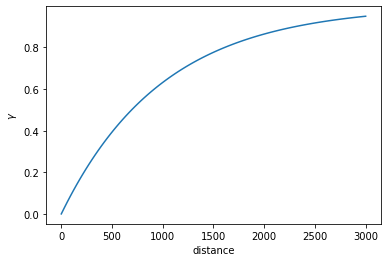

In [62]:
v_contribution = 1.0 # variance
v_range = 1000
exp_vario = pyemu.geostats.ExpVario(v_contribution,v_range)
exp_vario.plot()

now lets build a covariance matrix from x-y points.  We can generate these randomly or just use the pilot points template file:

In [63]:
df = pyemu.pp_utils.pp_tpl_to_dataframe(os.path.join(f_d,"hkpp.dat.tpl"))
df.head()

,name,x,y,zone,parnme
0,pp_0000,625.0,9375.0,1,hk00
1,pp_0001,1625.0,9375.0,1,hk01
2,pp_0002,2625.0,9375.0,1,hk02
3,pp_0003,3625.0,9375.0,1,hk03
4,pp_0004,625.0,8375.0,1,hk04


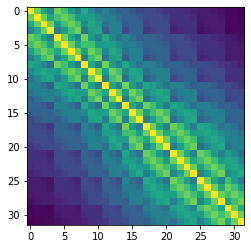

In [65]:
plt.imshow(pyemu.geostats.ExpVario(0.1,5000).covariance_matrix(df.x,df.y,df.name).x)

Here we will just use a 1-D sequence to get a cov matrix (think "time series")

In [66]:
times = np.arange(0,365,1)
y = np.ones_like(times)
names = ["t_"+str(t) for t in times]

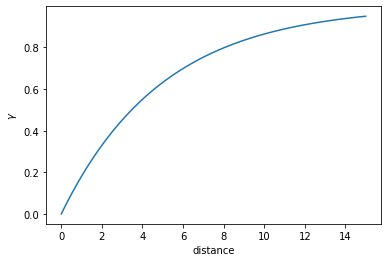

In [67]:
v_contribution = 1.0 # variance
v_range = 5 # days
exp_vario = pyemu.geostats.ExpVario(v_contribution,v_range)
exp_vario.plot()

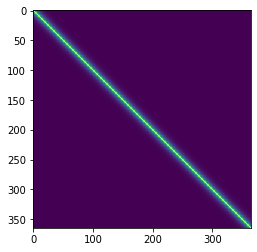

In [68]:
cov = exp_vario.covariance_matrix(times,y,names)
plt.imshow(cov.x)

### Ensembles

The pyemu ensemble class inherit from pandas DataFrame so all that nice stuff is included for free

In [69]:
pe = pyemu.ParameterEnsemble.from_gaussian_draw(pst=pst,cov=pyemu.Cov.from_parameter_data(pst),num_reals=1000)
pe.head()

,hk00,hk01,hk02,hk03,hk04,hk05,hk06,hk07,hk08,hk09,...,w0_r20_c14,w0_r26_c10,w0_r29_c06,w0_r34_c12,w1_r09_c16,w1_r11_c13,w1_r20_c14,w1_r26_c10,w1_r29_c06,w1_r34_c12
0,3.001833,2.366659,6.809490,3.429331,16.298398,1.547648,11.433005,3.922349,1.517295,4.300475,...,0.884188,0.724709,0.898494,0.855723,0.640158,0.172235,0.350420,1.214092,1.152578,7.065354
1,3.537170,1.463063,1.113342,35.310848,8.115535,8.310535,2.482060,18.759849,4.650216,1.116915,...,1.152560,1.149523,2.045370,0.950307,8.391324,0.668203,1.084015,0.360196,4.453099,2.613166
2,16.109007,9.537016,1.665155,14.723888,1.758288,24.733035,9.729475,4.196759,4.518557,1.296951,...,0.994265,2.694633,0.993588,0.964648,0.265094,1.133224,0.308936,1.516386,1.577233,4.764359
3,1.977936,3.282569,8.646999,3.203331,0.491054,2.210756,3.838319,15.149071,6.120960,3.712031,...,1.421224,1.798049,1.728568,1.241416,1.496314,1.079326,2.167345,0.346053,0.720999,7.031614
4,2.329271,3.773413,19.430744,5.431381,2.630756,13.805729,6.090457,2.434550,16.256617,10.085276,...,0.726211,1.147946,0.452868,0.709506,1.078538,0.261696,0.664994,0.660951,0.340216,0.897264


Check your understanding: where did the first (mean vector) and second (covariance matrix) moments come from in that ensemble generation?  

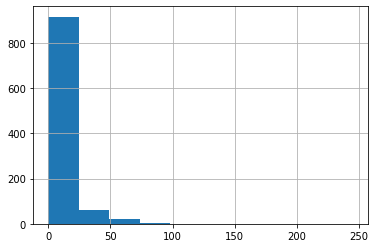

In [70]:
pe.iloc[:,0].hist()


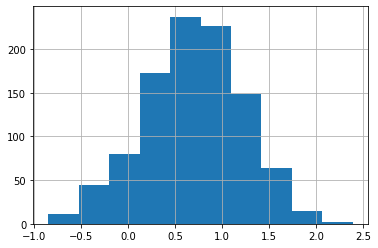

In [71]:
pe.iloc[:,0].apply(np.log10).hist()

So that was really easy...but what if we want to express spatial/temporal correlation in the prior?  that means we need to form mixed block-diagonal/diagonal cov matrix and then draw from it. In this case, we have spatially correlated pilot point parameters:

In [72]:
df = pyemu.pp_utils.pp_tpl_to_dataframe(os.path.join(f_d,"hkpp.dat.tpl"))
df.head()

,name,x,y,zone,parnme
0,pp_0000,625.0,9375.0,1,hk00
1,pp_0001,1625.0,9375.0,1,hk01
2,pp_0002,2625.0,9375.0,1,hk02
3,pp_0003,3625.0,9375.0,1,hk03
4,pp_0004,625.0,8375.0,1,hk04


Let's build a combined, block diagonal matrix:

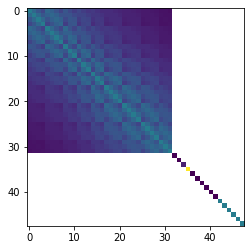

In [73]:
ev = pyemu.geostats.ExpVario(1.0,5000)
cov = pyemu.helpers.geostatistical_prior_builder(pst=pst,struct_dict={ev:df})
x = cov.x.copy()
x[x<1.0e-3] = np.NaN
plt.imshow(x)

This is exactly the same line as above except here the `cov` includes some off-diagonals for the pilot points

In [81]:
pe = pyemu.ParameterEnsemble.from_gaussian_draw(pst=pst,cov=cov,num_reals=100)
pe.head()

making full cov draws with home-grown goodness


,hk00,hk01,hk02,hk03,hk04,hk05,hk06,hk07,hk08,hk09,...,w0_r20_c14,w0_r26_c10,w0_r29_c06,w0_r34_c12,w1_r09_c16,w1_r11_c13,w1_r20_c14,w1_r26_c10,w1_r29_c06,w1_r34_c12
0,4.902656,4.186509,2.132429,3.616556,7.584204,3.169167,3.725573,4.566322,3.417780,1.641818,...,0.612541,1.124774,0.392794,0.790902,0.307155,1.275896,0.283202,0.159635,1.171909,0.709139
1,1.288249,0.682421,0.854037,2.291217,3.334321,2.616018,0.728766,1.419897,7.824258,1.162278,...,0.659479,0.556039,0.828789,1.136900,2.597358,0.635436,1.481751,2.581552,2.416007,2.754372
2,4.149976,7.153476,9.129349,4.393417,1.153396,2.492120,4.725330,9.222146,0.918446,2.678476,...,0.904278,0.562873,1.392803,1.052671,13.153803,2.027360,2.480771,0.151920,1.267293,1.401857
3,11.242266,8.027103,11.864142,11.598711,9.836163,29.561417,34.432265,21.679933,8.518913,15.224094,...,0.765837,0.700559,1.163386,1.650801,2.534910,0.657244,0.351216,0.986696,0.681325,6.858661
4,5.267674,2.410335,3.251210,4.717527,3.987209,2.627577,4.909662,18.534199,6.240842,11.000535,...,0.766339,0.900413,1.018948,1.669264,2.105494,0.174286,1.010572,1.483100,0.447194,12.768122


Lets plot the values of the pilot points in space to see their correlation (or lack thereof)

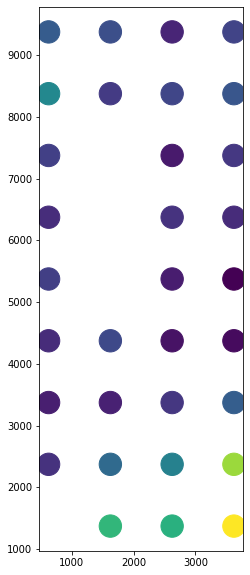

In [82]:
df.index = df.parnme
df.loc[:,"parval1"] = pe.loc[0,df.parnme]
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111,aspect="equal")
plt.scatter(df.x,df.y,c=df.parval1,s=500)

You can "kind of" see that correlation, but if we krige these values to the model grid, we can really see it...

In [83]:
df.loc[:,"parval1"] = pe.loc[0,df.parnme]
df.index = np.arange(df.shape[0])
arr = pyemu.geostats.fac2real(df,factors_file=os.path.join(f_d,"hkpp.dat.fac"),out_file=None)

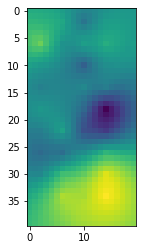

In [84]:
plt.imshow(np.log10(arr))

### DIY: experiment with changing the variogram range and seeing how it changes the resulting parameter fields

FORESHADOWING: we can also form an empirical covariance matrix from this par ensemble!

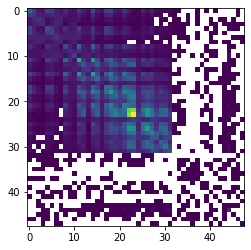

In [85]:
emp_cov = pe.covariance_matrix()
x = emp_cov.x.copy()
x[x<1.0e-3] = np.NaN
plt.imshow(x)